# Smoothing particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_smoothing as plt_sp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import smoothing_particles as sp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

ordering = True
video_name = "2n_2m_0f_240216_1"
n_particles = int(video_name[0])
save_figures = True
x_bounds = [0, 1080]
y_bounds = [60, 1850]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Load tracked data

In [3]:
df_tracked = pd.read_csv("{}/clustered_{}.csv".format(output_path, video_name), low_memory=False)
df_tracked.head(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1727.527664,495.458811,1727.658619,496.333293,NaN,1727.527664,495.458811,NaN,1727.527664,495.458811,-0.002989,4880.0,132.015826,62.921381,0.879109,2,NaN,NaN,NaN,NaN,False,False,False
1,1,0,1570.642375,986.308463,1571.390783,984.520214,NaN,1570.642375,986.308463,NaN,1570.642375,986.308463,-1.543950,10374.0,222.382994,92.591304,0.909200,2,NaN,NaN,NaN,NaN,False,False,False


In [4]:
df_tracked.tail(n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
71344,0,107997,1728.794262,283.630154,1729.821707,287.644215,0.0,1728.794262,283.630154,0.419608,1728.794262,283.630154,0.078626,6498.0,140.400034,69.358261,0.869459,2,3.0,-0.019721,0.06963,0.0,False,False,False
71345,1,107997,1736.447887,408.637089,1740.271642,408.404104,NaN,1736.447887,408.637089,NaN,1736.447887,408.637089,-0.141065,2130.0,155.205830,59.849519,0.922660,2,3.0,0.000000,0.00000,0.0,False,False,False


## Swapping mixed IDs

In [5]:
omega_threshold = 20 * np.pi / 180  # Angular velocity per frame (in degrees)
velocity_threshold = 83  # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
delta = 400

from importlib import reload
reload(sp)

arg_list = [
    # VIDEO 1
    [0    , 10000, velocity_threshold, omega_threshold, True],
    [10000, 20000, velocity_threshold, omega_threshold, True],
    [20000, 30000, velocity_threshold, omega_threshold, True],
    [30000, 40000, velocity_threshold, omega_threshold, True],
    [40000, 50000, velocity_threshold, omega_threshold, True],
    [50000, 60000, velocity_threshold, omega_threshold, True],
    [60000, 70000, velocity_threshold, omega_threshold, True],
    [70000, 80000, velocity_threshold, omega_threshold, True],
    [80000, 90000, velocity_threshold, omega_threshold, True],
    [90000, 100000, velocity_threshold, omega_threshold, True],
    [100000, 108000, velocity_threshold, omega_threshold, True]
]

df_final = sp.smooth_frames(
    df_tracked=df_tracked,
    arg_list=arg_list,
    order=False,
    log_path=log_path,
    log_filename="log_{}".format(video_name),
    verbose=1,
    tqdm_bar=True
)

df_final.head(8)

Thresholds:
	- Velocity: 83 
	- Angle: 20.0 



100%|███████████████████████| 11/11 [00:17<00:00,  1.61s/it]


Time: 30000 Chunks 2 Allowed time 30000 Permutation [0 1]
Time: 60000 Chunks 2 Allowed time 60000 Permutation [0 1]
Time: 90000 Chunks 2 Allowed time 89847 Permutation [0 1]


,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,True,0,chunk_00000_10000,0,0,1727.527664,495.458811,1727.658619,496.333293,NaN,1727.527664,495.458811,NaN,1727.527664,495.458811,-0.002989,-0.002989,4880.0,132.015826,62.921381,0.879109,2,NaN,NaN,NaN,NaN,False,False,False
1,True,0,chunk_00000_10000,1,1,1570.642375,986.308463,1571.390783,984.520214,NaN,1570.642375,986.308463,NaN,1570.642375,986.308463,-1.543950,-1.543950,10374.0,222.382994,92.591304,0.909200,2,NaN,NaN,NaN,NaN,False,False,False
2,True,3,chunk_00000_10000,0,0,1727.514589,495.487452,1727.623350,496.364697,NaN,1727.514589,495.487452,NaN,1727.514589,495.487452,-0.007734,-0.007734,4901.0,131.849388,62.904680,0.878852,2,3.0,-0.004358,0.009547,-0.001582,False,False,False
3,True,3,chunk_00000_10000,1,1,1571.040946,986.203573,1572.393670,984.357325,NaN,1571.040946,986.203573,NaN,1571.040946,986.203573,-1.543219,-1.543219,10355.0,219.997343,92.764577,0.906753,2,3.0,0.132857,-0.034963,0.000244,False,False,False
4,True,6,chunk_00000_10000,0,0,1727.522973,495.483766,1727.633026,496.359169,NaN,1727.522973,495.483766,NaN,1727.522973,495.483766,-0.007602,-0.007602,4897.0,131.785410,62.915471,0.878681,2,3.0,0.002795,-0.001229,0.000044,False,False,False
5,True,6,chunk_00000_10000,1,1,1570.794689,986.134789,1572.115691,984.275019,NaN,1570.794689,986.134789,NaN,1570.794689,986.134789,-1.544316,-1.544316,10394.0,220.248104,92.660529,0.907195,2,3.0,-0.082086,-0.022928,-0.000366,False,False,False
6,True,9,chunk_00000_10000,0,0,1727.447206,495.289441,1727.548037,496.139096,NaN,1727.447206,495.289441,NaN,1727.447206,495.289441,-0.010953,-0.010953,4868.0,131.710552,62.794736,0.879032,2,3.0,-0.025256,-0.064775,-0.001117,False,False,False
7,True,9,chunk_00000_10000,1,1,1570.879022,986.281476,1572.163420,984.454641,NaN,1570.879022,986.281476,NaN,1570.879022,986.281476,-1.542327,-1.542327,10349.0,220.352657,92.471260,0.907685,2,3.0,0.028111,0.048896,0.000663,False,False,False


In [6]:
df_final.tail(5)

,allowed_frame,time,smooth_chunk,id,permuted_id,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,corrected_orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
71341,True,107991,chunk_100000_108000,1,1,1736.447887,408.637089,1740.271642,408.404104,NaN,1736.447887,408.637089,NaN,1736.447887,408.637089,-0.141065,-0.141065,2130.0,155.205830,59.849519,0.922660,2,3.0,0.000000,0.000000,0.0,False,False,False
71342,True,107994,chunk_100000_108000,0,0,1728.853424,283.421264,1729.940571,287.274244,0.0,1728.853424,283.421264,0.419608,1728.853424,283.421264,0.078626,0.078626,6498.0,140.400034,69.358261,0.869459,2,3.0,0.017345,-0.041198,0.0,False,False,False
71343,True,107994,chunk_100000_108000,1,1,1736.447887,408.637089,1740.271642,408.404104,NaN,1736.447887,408.637089,NaN,1736.447887,408.637089,-0.141065,-0.141065,2130.0,155.205830,59.849519,0.922660,2,3.0,0.000000,0.000000,0.0,False,False,False
71344,True,107997,chunk_100000_108000,0,0,1728.794262,283.630154,1729.821707,287.644215,0.0,1728.794262,283.630154,0.419608,1728.794262,283.630154,0.078626,0.078626,6498.0,140.400034,69.358261,0.869459,2,3.0,-0.019721,0.069630,0.0,False,False,False
71345,True,107997,chunk_100000_108000,1,1,1736.447887,408.637089,1740.271642,408.404104,NaN,1736.447887,408.637089,NaN,1736.447887,408.637089,-0.141065,-0.141065,2130.0,155.205830,59.849519,0.922660,2,3.0,0.000000,0.000000,0.0,False,False,False


## Interpolation over not allowed frames

In [7]:
if ordering:
    df_full = df_final.copy().sort_values(["time", "permuted_id"])
    for id_ in range(len(df_full["permuted_id"].unique())):
        mask = df_full.loc[:,"permuted_id"]==df_full["permuted_id"].unique()[id_]
        df_full[mask]=df_full[mask].interpolate(method="linear")

In [8]:
if ordering:
    cols = [
        "id", "permuted_id", "time", "position_x", "position_y", "weighted_x", "weighted_y",
        "darkest_v", "darkest_x", "darkest_y", "lightest_v", "lightest_x", "lightest_y",
        "orientation", "corrected_orientation", "area", "axis_major", "axis_minor", "eccentricity"
    ]
    df_temp = df_full[cols]
    df_temp.to_csv("{}/interpolated_{}.csv".format(output_path, video_name), index=False)
    df_temp

Thresholds:
	- Velocity: 17.313283512632715 
	- Angle: 11.113842601865132 



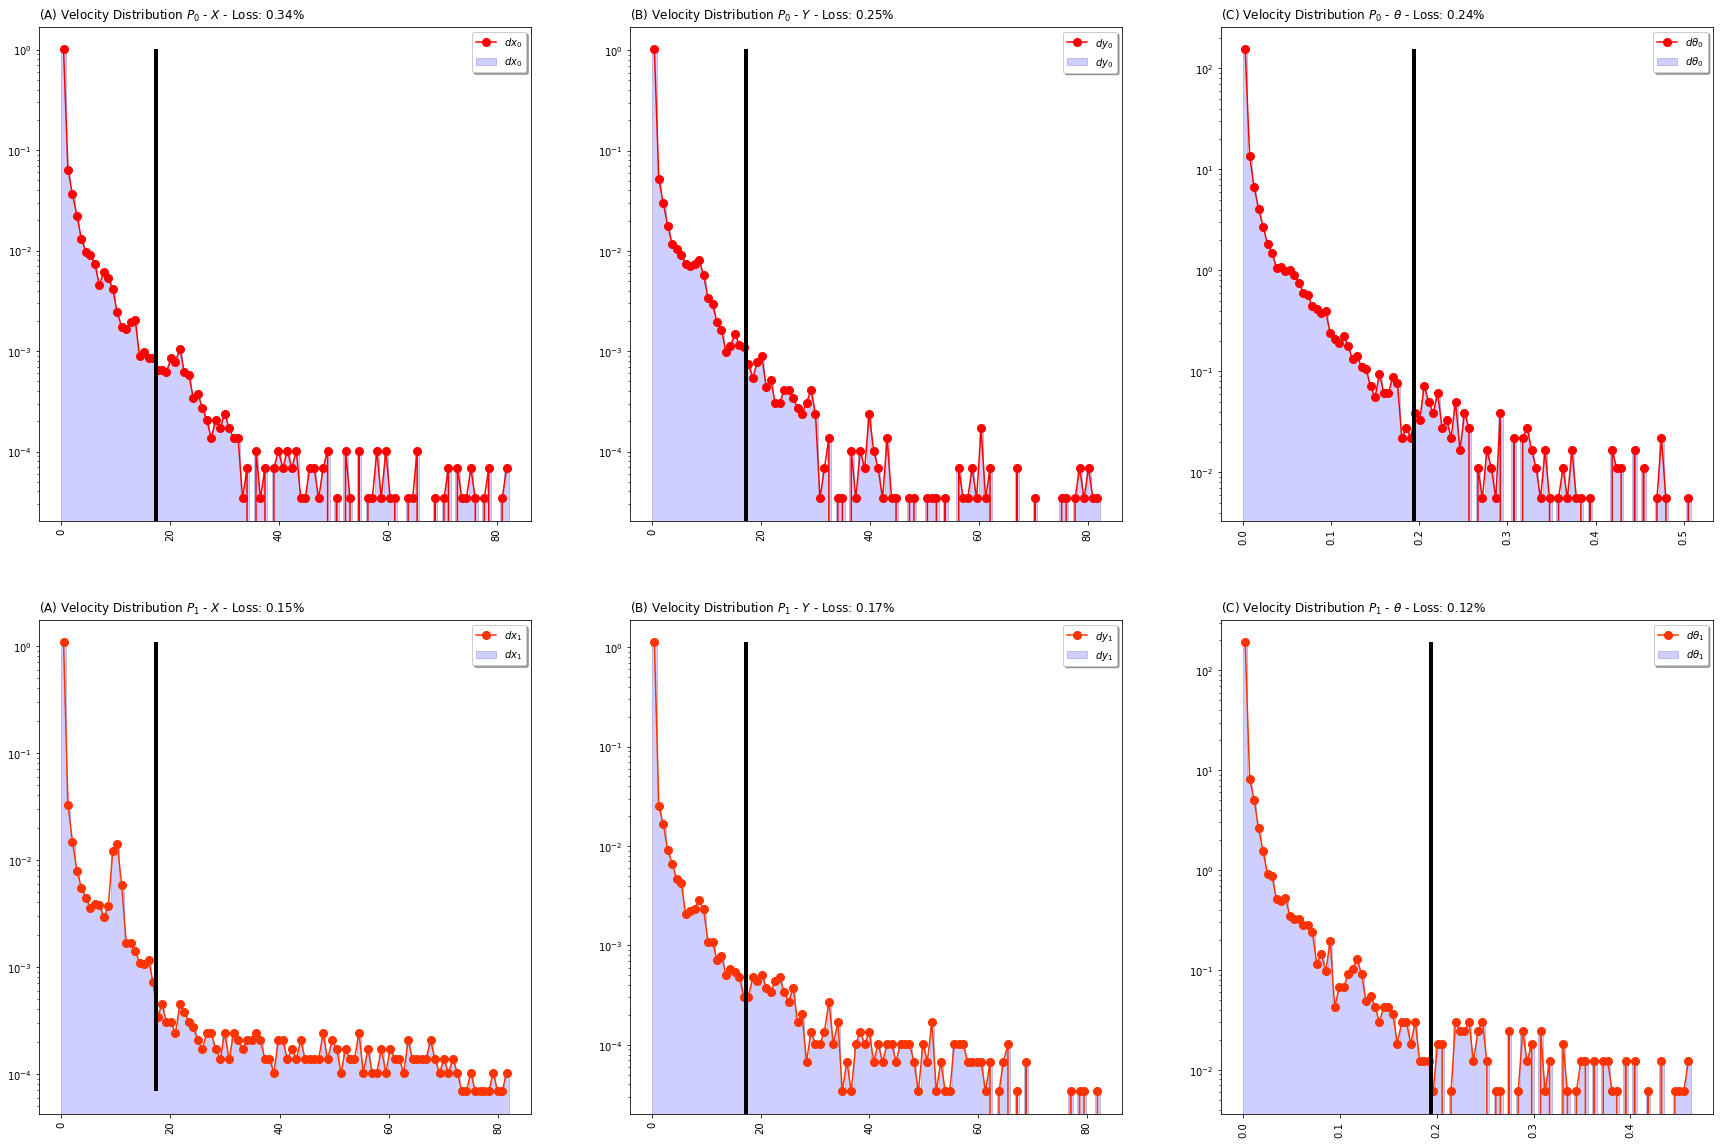

In [9]:
if ordering:
    bins = 100
    width = 10
    fancy_legend = True
    omega_threshold = df_full["velocity_orientation"].abs().quantile(0.9965) # Angular velocity per frame
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9901) # Velocity per frame limited with half average size of particle
    print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_cp.plot_velocities_distribution(
        df_tracked=df_smooth,
        bins=bins,
        velocity_threshold=velocity_threshold,
        omega_threshold=omega_threshold,
        width=width,
        fancy_legend=fancy_legend
    )

Original


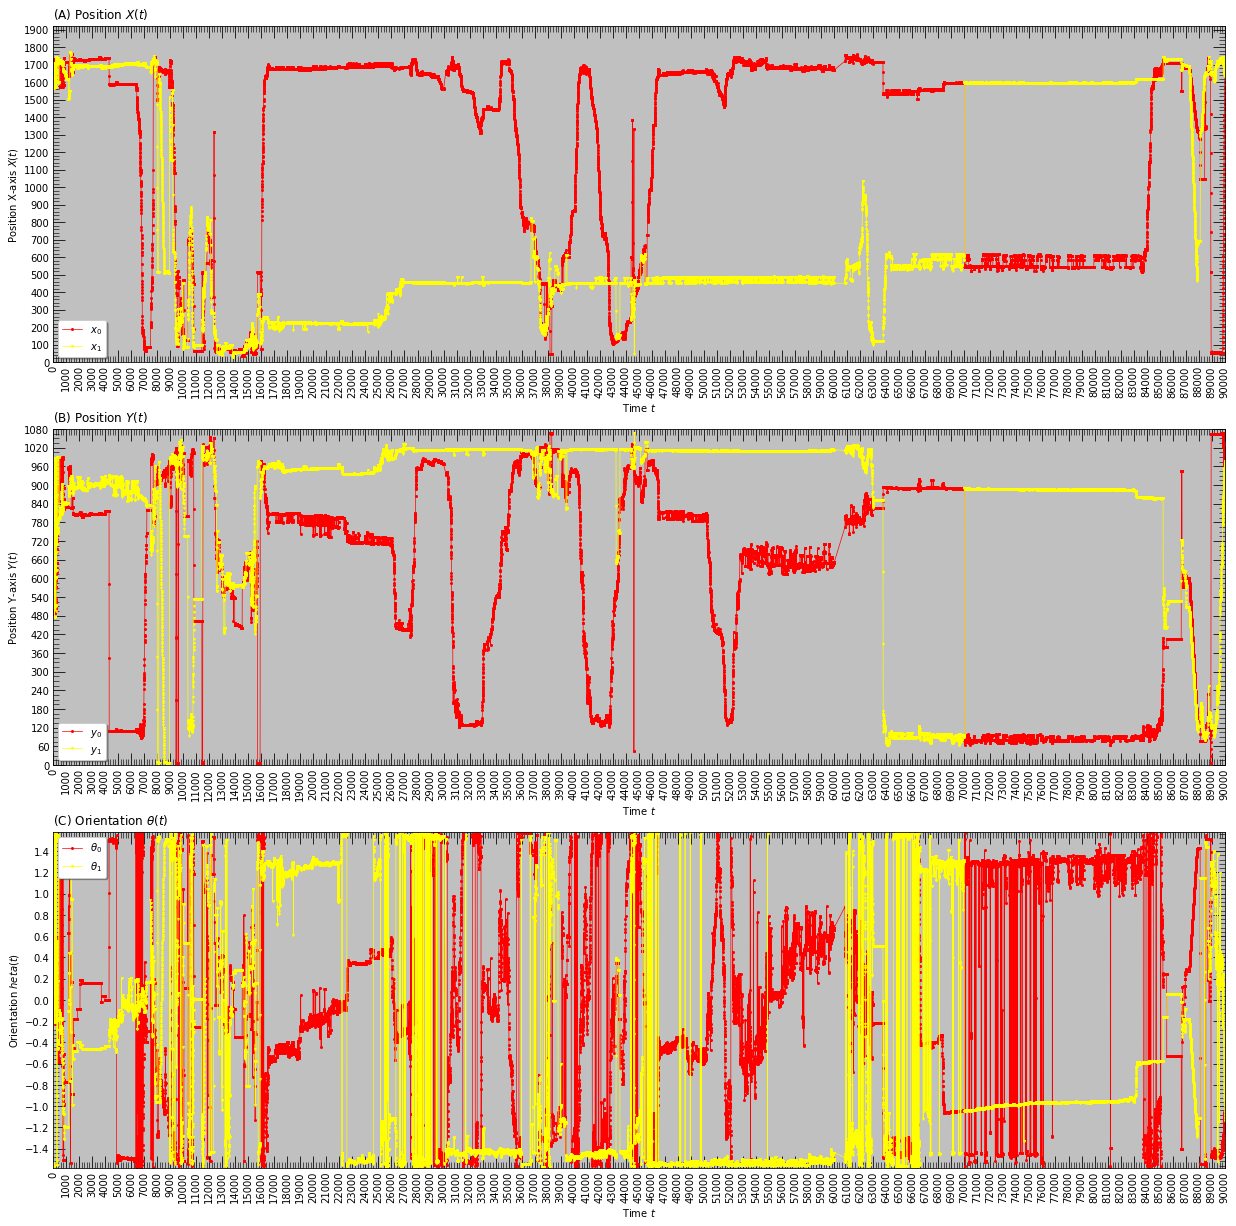

Corrected Orientation


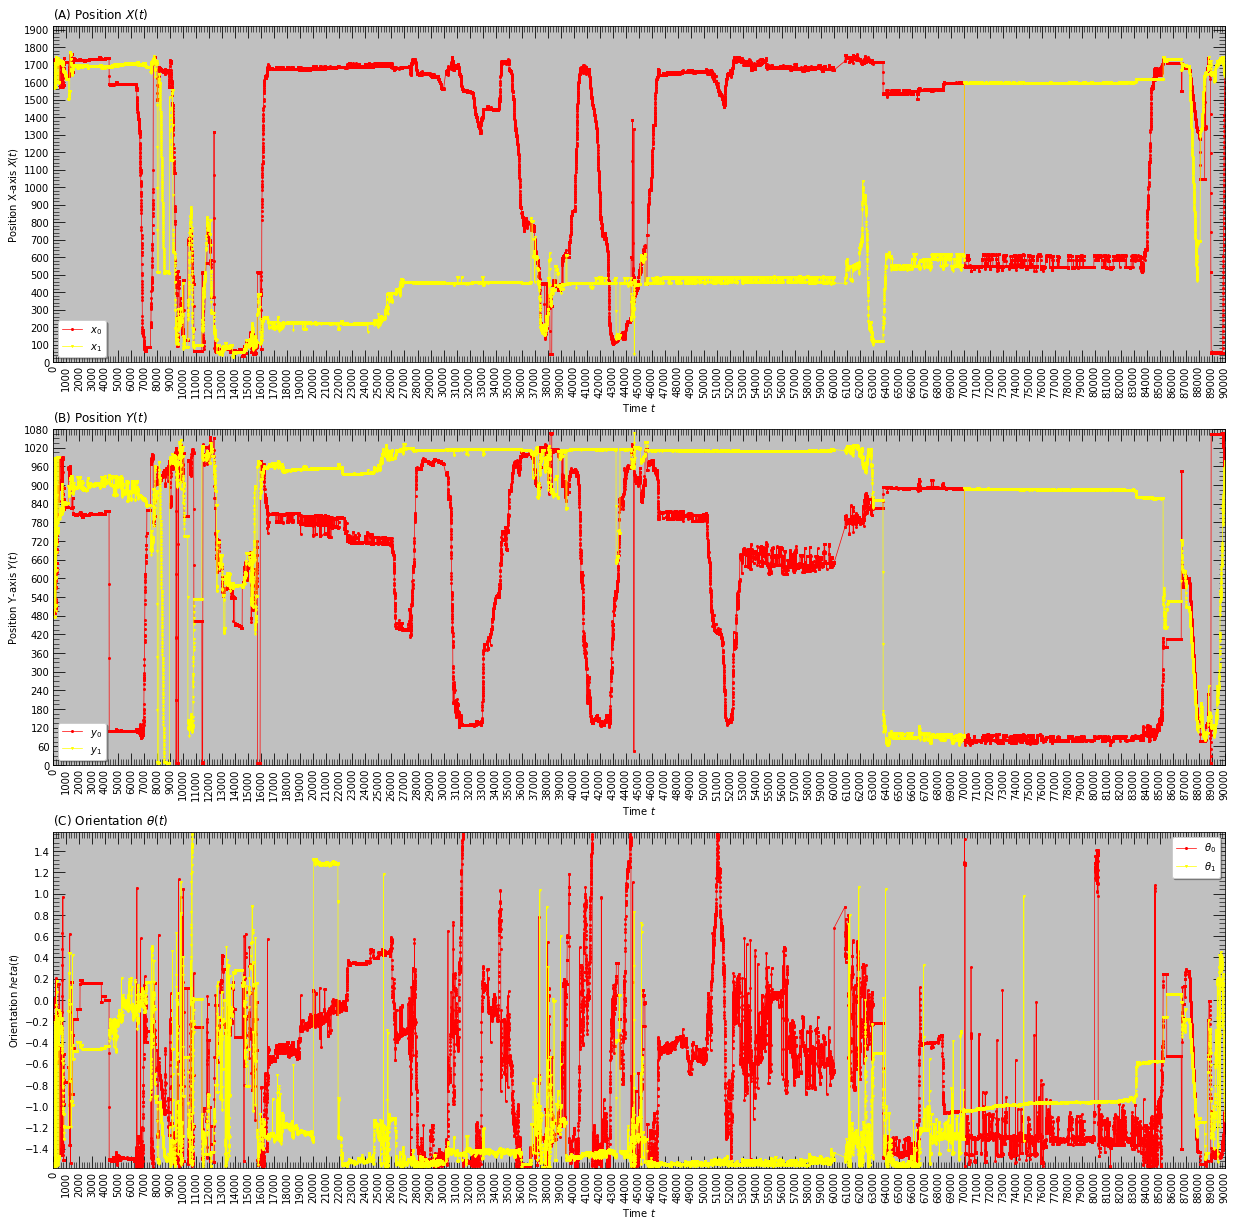

In [10]:
if ordering:
    width = 21
    n_x_breaks = 100
    n_y_breaks = 20
    t0, tf   = 0, 90000  # 22200, 24300
    t0_, tf_ = 0, 90000  # 22200, 24300
    t_bounds = [t0_, tf_]
    p_bounds = [[0, 1920], [0, 1080], [-1.58, 1.58]]
    fancy_legend = True

    print("Original")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    velocity_threshold = df_full["velocity_x"].abs().quantile(0.9701) # Velocity per frame limited with half average size of particle
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

    print("Corrected Orientation")
    df_smooth = df_full.copy()
    df_smooth["id"] = df_smooth["permuted_id"]
    df_smooth["orientation"] = df_smooth["corrected_orientation"]
    plt_sp.plot_tracking_evolution(
        df_smooth=df_smooth[((df_smooth["velocity_x"] <= velocity_threshold) & (df_smooth["velocity_y"] <= velocity_threshold))],
        width=width,
        n_x_breaks=n_x_breaks,
        n_y_breaks=n_y_breaks,
        t_bounds=[t0, tf],
        p_bounds=p_bounds,
        fancy_legend=fancy_legend
    )

## Setting video information

In [11]:
# # Load the video
# reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# # Check the number of frames
# num_frames = reader.count_frames()
# print("Total frames: {}".format(num_frames))

# # Extract a frame to inspect the content
# time = 0
# frame = reader.get_data(time)
# print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

## Comparative of process

In [12]:
# # Original frame
# time = 209  #271  # 209  # 80
# times = [time - 1, time, time + 1]
# reinforce_boundaries = True
# remove_holes = False
# type = "local equalized"
# clip_limit = 0.05
# threshold = 0.19
# sigma = 1.5
# x_bounds = x_bounds  # [40, 1020]
# y_bounds = y_bounds  # [160, 1740]
# region_area_min = 200
# axis_major_min = 94
# eccentricity_max = 0.99


# df_tracked_frame_0 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[0], reader.get_data(times[0])]
# )

# df_tracked_frame_1 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[1], reader.get_data(times[1])]
# )

# df_tracked_frame_2 = tp.process_frame(
#     reinforce_boundaries=reinforce_boundaries,
#     remove_holes=remove_holes,
#     type=type,
#     clip_limit=clip_limit,
#     threshold=threshold,
#     sigma=sigma,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     region_area_min=region_area_min,
#     axis_major_min=axis_major_min,
#     eccentricity_max=eccentricity_max,
#     tracking_list=[times[2], reader.get_data(times[2])]
# )

# df_tracked_old = pd.concat([df_tracked_frame_0, df_tracked_frame_1, df_tracked_frame_2], ignore_index=True)

# width = 10
# n_x_breaks = 20
# n_y_breaks = 20
# fancy_legend = True
# x_legend = 1.001
# y_legend = 0.891

# df_smooth = df_full.copy()
# df_smooth["id"] = df_smooth["permuted_id"]
# df_smooth["orientation"] = df_smooth["corrected_orientation"]

# fig = plt_sp.plot_all_process_frame(
#     reader=reader,
#     times=times,
#     df_tracked=df_tracked_old,
#     df_clustered=df_tracked,
#     df_smoothed=df_smooth,
#     width=width,
#     n_x_breaks=n_x_breaks,
#     n_y_breaks=n_y_breaks,
#     x_bounds=x_bounds,
#     y_bounds=y_bounds,
#     fancy_legend=fancy_legend,
#     x_legend=x_legend,
#     y_legend=y_legend
# )